# <center> <b> <font color='blue'> AIR QUALITY </center> </b> </font>

## Table of Contents

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Loading and Pre-processing data](#4)
5. [Models](#5) <br>
    5.1. [Dense Model](#5.1) <br>
    5.2. [LSTM](#5.2) <br>
    5.3. [LSTM with Data Normalization](#5.3) <br>
6. [Annex](#annex) <br>
    A. [About standarization](#A)
7. [References](#References)

<a name="1"></a>
## <font color='#1a5276'> <b> 1. Introduction </font> </b>

This notebook explores how to approach a multivariate time series forecasting problem using deep learning, with a focus on learning and understanding the process.

We will walk through the key steps involved in preparing time series data with multiple variables, building deep learning models (starting with dense and LSTM architectures), and making forecasts. The goal is not just performance, but also to gain insight into the workflow, challenges, and reasoning behind each step.

This notebook is ideal for those who want a hands-on, educational guide to tackling real-world time series problems using neural networks.

<a name="2"></a>
## <font color='#1a5276'> <b> 2. Setup </font> </b>

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass

In [10]:
tf.random.set_seed(42)

In [11]:
@dataclass
class G:
    BATCH_SIZE = 64
    SHUFFLE_BUFFER_SIZE = 200
    SPLIT_SIZE=0.8

In [12]:
np.set_printoptions(
    precision=3,      # Number of decimal places
    suppress=True,    # Suppress scientific notation for small numbers
    linewidth=120     # Maximum characters per line for wrapping
)

**Nomenclature**

In this notebook, we’ll use the following terms:

- Horizon: The output size of the model—that is, how many future steps it predicts at once.

- Forecast horizon: How far ahead we want to predict by applying the model recursively. Beyond this point, we assume new data will be available, and the model can be retrained.

Since we’ll be using rolling forecasting, the horizon will be set to 1, meaning the model predicts only the next time step at each iteration.

<a name="3"></a>
## <font color='#1a5276'> <b> 3. Helper Functions </font> </b>

#### Plots

In [13]:
def plot_time_series(time, series, title, xlabel, ylabel, label, figsize=(8, 6)):
    """
    Plot time series
    """
    plt.figure(figsize=figsize)
    plt.plot(time, series, label=label, color='blue')

    # Set the title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    # Set custom ticks on the x-axis
    # Choose the indices or specific timestamps you want to mark
    tick_indices = np.arange(0, len(time), 100)  # Example: every 100th index
    plt.xticks(ticks=time[tick_indices], rotation=45)  # Rotate for better visibility

    plt.tight_layout()  # Adjust layout to make room for tick labels
    plt.show()
    
    
def plot_features_vs_target(data):
    """
    Plots the features against the target
    """
    # Assuming data shape is (num_samples, 6) where the first column is temperature
    temperature = data[:, 0]

    # Create scatter plots for each feature against temperature
    plt.figure(figsize=(15, 10))

    for i in range(1, data.shape[1]):  # Start from 1 to skip the temperature column
        plt.subplot(3, 2, i)  # Adjust the layout based on the number of features
        plt.scatter(data[:, i], temperature, alpha=0.5)
        plt.title(f'Feature {i} vs Temperature')
        plt.xlabel(f'Feature {i}')
        plt.ylabel('Temperature')

    plt.tight_layout()
    plt.show()
    
    
def plot_history(history):
    # Assuming `history` is the output from model.fit()
    # Example: history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)  # One row, two columns, first subplot
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot training & validation MSE
    plt.subplot(1, 2, 2)  # One row, two columns, second subplot
    plt.plot(history.history['mse'], label='Training MSE')
    if 'val_mse' in history.history:
        plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.title('Model Mean Squared Error')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    


# plot comparison
def plot_comparison(test_labels, forecast, forecast_horizon, name): #test labels should be
                    # already skipped window size
        plt.figure(figsize=(8, 5))
        plt.plot(test_labels[:forecast_horizon], label="Actual", marker='o')
        plt.plot(forecast, label="Forecast", marker='x')
        #if X_test is not None:
        #    plt.plot(X_test[-validation_steps:], label="Feature 1 (e.g., Humidity)", linestyle="--", alpha=0.5)
        plt.title(f"Multivariate Forecast vs Actual — {name}")
        plt.xlabel("Time Step")
        plt.ylabel("Target Value (Feature 0)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    

#### Train/Test split

In [14]:
def train_test_split_time_series(data, split_size=G.SPLIT_SIZE):
    """Splits a multivariate time series into training and testing sets, ensuring temporal order.

    Args:
        data: numpy array
        spli_size (float, optional): Proportion of data to be used for training.

    Returns:
        tuple: A tuple containing the training and testing sets.
    """

    # Determine the split point based on the test size
    split_point = int(len(data) * split_size)

    # Split the data into training and testing sets, preserving time order
    train_data = data[:split_point]
    test_data = data[split_point:]

    return train_data, test_data

#### Windowing

In [15]:
def windowed_dataset(data, window_size, batch_size, shuffle_buffer, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    
    # Create sliding windows of size window_size + 1 (for the label)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the dataset and create feature/label pairs
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Features: previous 5 values of both T and h (columns 0 and 1 respectively)
    # Target: next temperature value (T at t+1, column 0 of the last row in the window)
    dataset = dataset.map(lambda window: (window[:-1, :], window[-1, 0]))  
            # 'window[:-1, :]' gets 5 values of T and the others features, 'window[-1, 0]' gets T(t+1)
    
    # Shuffle, batch, and prefetch
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


#### Forecast

In [16]:
def make_forecast(model, initial_window, num_predictions, verbose=False):
    """
    Forecast future temperature values using a naive multivariate approach:
    - Predict temperature (column 0)
    - Keep all other features fixed from the previous time step

    Parameters:
    - model: Trained model
    - initial_window: np.array of shape (window_size, num_features)
    - num_predictions: int, number of steps to forecast
    - verbose: bool, print debugging info if True

    Returns:
    - np.array of predicted temperature values
    """
    
    predictions = []
    current_window = initial_window.copy()

    for _ in range(num_predictions):
        # Predict the next temperature
        pred = model.predict(current_window[np.newaxis], verbose=0)
        pred_temp = pred[0][0]  # Extract scalar value

        if verbose:
            print(f"Input window:\n{current_window}\nPredicted temp: {pred_temp}\n")

        # Append prediction
        predictions.append(pred_temp)

        # Create next row:
        # - Column 0: predicted temperature
        # - Columns 1-5: copy from last row in current_window
        next_row = current_window[-1].copy()
        next_row[0] = pred_temp  # update only temperature

        # Shift window and append new row
        current_window = np.roll(current_window, -1, axis=0)
        current_window[-1] = next_row

    return np.array(predictions)


**Note**

In our forecasting setup, we aim to predict only the temperature based on a set of input features. Instead of directly modifying the last row by setting current_window[-1, 0] = pred_step, we take a more structured approach: we copy the entire last row, update only the temperature (first column) with the predicted value, and use this modified row as the next input step.

All other features are preserved from the previous time step.

This follows a naive strategy, where we assume that the non-predicted features (e.g., humidity, wind speed, etc.) remain constant over time. While simplistic, this approach is often reasonable when future values of those features are unknown or unavailable at prediction time.

#### Evaluation

In [17]:
# get first true values of the test dataset to compare
def get_first_n_samples(dataset, n):
    x_list = []
    y_list = []
    count = 0

    for x_batch, y_batch in dataset:
        for x, y in zip(x_batch, y_batch):
            x_list.append(x)
            y_list.append(y)
            count += 1
            if count >= n:
                return tf.stack(x_list), tf.stack(y_list)

    return tf.stack(x_list), tf.stack(y_list)  # in case n > total samples


# get labels skipping the first window size values
def get_true_future_labels(dataset, window_size, steps_ahead):
    _, y = get_first_n_samples(dataset, window_size + steps_ahead)
    return y[window_size:]  # skip the initial window


# get initial window
def get_initial_window(dataset):
    """
    Extracts the first input window from a tf.data.Dataset.

    Parameters:
    - dataset: A tf.data.Dataset yielding (x, y) batches where x has shape (batch_size, window_size, num_features)

    Returns:
    - initial_window: np.array of shape (window_size, num_features)
    """
    for x_batch, _ in dataset.take(1):
        initial_window = x_batch[0].numpy()
        return initial_window


In [18]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
 
    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [19]:
# fn. that combines preds and evaluation
def pred_eval(model, initial_window, test_labels, X_test, validation_steps=50, do_plot=True):
    """
    Makes a forecast using a trained multivariate model, evaluates the predictions, and optionally plots the results.

    Parameters:
    - model: Trained model used for forecasting.
    - initial_window: Initial multivariate window (e.g., last N time steps) of shape (window_size, num_features).
    - test_labels: True future values of the target (e.g., temperature at t+1) as a 1D array.
    - X_test: Optional second feature (e.g., humidity) to show in the plot, shape (validation_steps,).
    - validation_steps: Number of steps to forecast and evaluate.
    - do_plot: Whether to plot the forecast vs. actual values.

    Returns:
    - forecast: Numpy array of predicted values.
    - results: Dictionary with evaluation metrics.
    """
    
    # Make forecast using the multivariate method
    forecast = make_forecast(model, initial_window, validation_steps, verbose=False)

    # Evaluate predictions against the true values
    results = evaluate_preds(test_labels[:validation_steps], forecast)
    
    # Plot comparison if requested
    if do_plot:
        plot_comparison(test_labels, forecast, validation_steps, model.name)

    # return
    return forecast, results



<a name="4"></a>
## <font color='#1a5276'> <b> 4. Loading and pre-processing data </font> </b>

DATASET


Vito, S. (2008). Air Quality [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C59K5F.


https://archive.ics.uci.edu/dataset/360/air+quality

#### Dataset info

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2)  and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. 

Missing values are tagged with -200 value.


#### Loading data

In [28]:
# Load the dataset
df = pd.read_csv('data/air+quality/AirQualityUCI.csv', sep=';', decimal=',', parse_dates=[['Date', 'Time']], 
                 na_values=-200)

# Drop the unnamed columns and rows with NaN values
df_clean = df.drop(columns=['Unnamed: 15', 'Unnamed: 16']).dropna()

# Set the Date_Time as the index
df_clean = df_clean.set_index('Date_Time')

# Select the relevant features and the target variable
df_filtered = df_clean[['T', 'CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'RH', 'AH']]

In [29]:
df_filtered.head()

,T,CO(GT),NMHC(GT),C6H6(GT),RH,AH
Date_Time,,,,,,
10/03/2004 18.00.00,13.6,2.6,150.0,11.9,48.9,0.7578
10/03/2004 19.00.00,13.3,2.0,112.0,9.4,47.7,0.7255
10/03/2004 20.00.00,11.9,2.2,88.0,9.0,54.0,0.7502
10/03/2004 21.00.00,11.0,2.2,80.0,9.2,60.0,0.7867
10/03/2004 22.00.00,11.2,1.6,51.0,6.5,59.6,0.7888


We want to predict temperature given the other values, therefore D=5 (the number of features is 5).

In [30]:
df_filtered.shape

(827, 6)

In [31]:
time = df_filtered.index.values
time[-2:]

array(['30/04/2004 23.00.00', '01/05/2004 00.00.00'], dtype=object)

In [32]:
# Convert dataframe to NumPy array for TensorFlow compatibility
data = df_filtered.values

#### Visualization

Remember

- data[:, 0] refers to the first column of the array (Temperature, which in this case is the target)

- data[:, 1] refers to the second column (CO(GT))

- data[:, 2] refers to the third column.

- data[:, 3] refers to the fourth column.

- data[:, 4] refers to the fifth column.

- data[:, 5] refers to the sixth column.

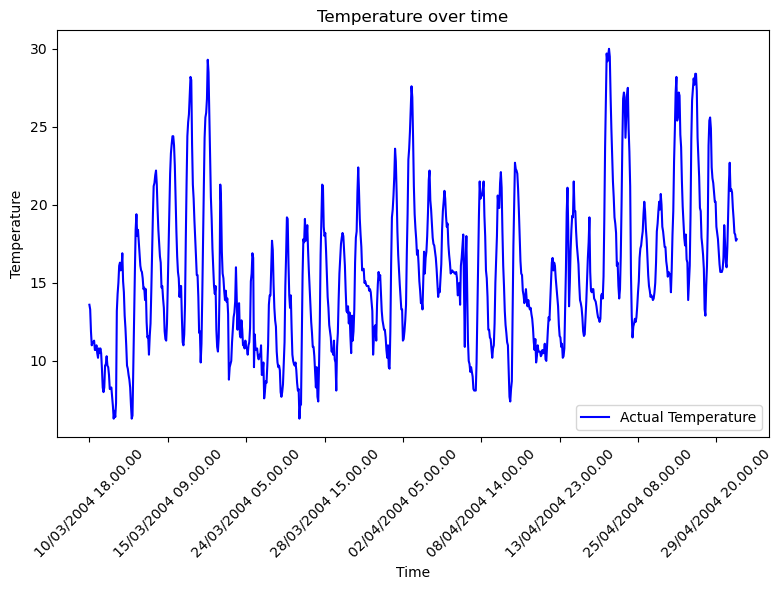

In [506]:
plot_time_series(time, data[:, 0], 'Temperature over time' ,'Time', 'Temperature', 'Actual Temperature')

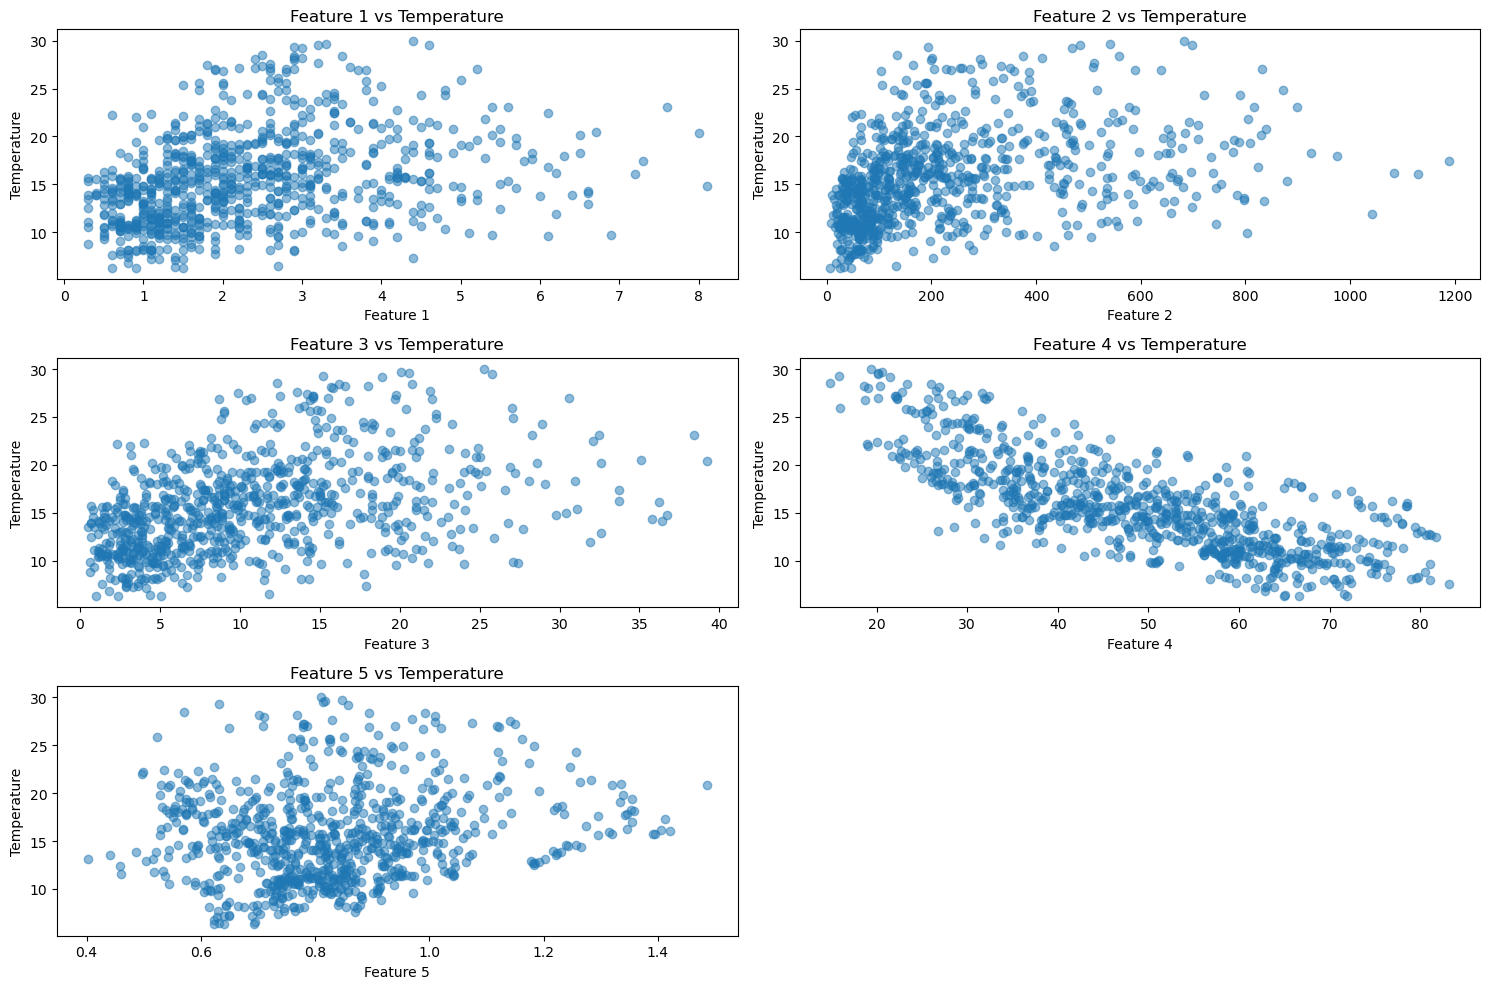

In [507]:
plot_features_vs_target(data)

### Correlation matrix

In [508]:
# Calculate the correlation matrix
correlation_matrix = df_filtered.corr()

# Print the entire correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                 T    CO(GT)  NMHC(GT)  C6H6(GT)        RH        AH
T         1.000000  0.318261  0.366976  0.418409 -0.769869  0.159964
CO(GT)    0.318261  1.000000  0.887167  0.972660 -0.105157  0.295591
NMHC(GT)  0.366976  0.887167  1.000000  0.897928 -0.160257  0.282142
C6H6(GT)  0.418409  0.972660  0.897928  1.000000 -0.178410  0.313415
RH       -0.769869 -0.105157 -0.160257 -0.178410  1.000000  0.475776
AH        0.159964  0.295591  0.282142  0.313415  0.475776  1.000000


#### 🔍 Correlation Analysis for T (Temperature)


- **Strongest correlation:**
  - RH (Relative Humidity): -0.77
    Temperature is strongly negatively correlated with relative humidity. As temperature increases, relative humidity tends to decrease — a relationship that aligns with basic atmospheric physics.


- **Moderate positive correlations:**
  - C6H6(GT): 0.42
  - NMHC(GT): 0.37
  - CO(GT): 0.32  
    These pollutants show moderate positive correlations with temperature, possibly indicating that higher temperatures are associated with increased emissions or chemical activity.


- **Weak correlation:**
  - AH (Absolute Humidity): 0.16  
    Temperature has a weak positive correlation with absolute humidity. While warmer air can hold more moisture, this relationship is influenced by broader weather conditions.

---

#### ✅ Conclusion

- Temperature is **most strongly and negatively influenced by relative humidity (RH)**.
- It has **moderate positive correlations** with several air pollutants.
- These insights suggest that **RH and pollutant levels** could be informative features when building a model to predict temperature.

Because of this, we will remove the **AH** feature.


In [33]:
data.shape

(827, 6)

In [34]:
# Remove the 6th column (AH → index 5)
data = np.delete(data, 5, axis=1)
data.shape

(827, 5)

#### Train/test split

In [35]:
train_data, val_data = train_test_split_time_series(data)

In [36]:
train_data.shape, val_data.shape

((661, 5), (166, 5))

#### Windowing

Let's test our windowing function with a window size of 2 and a batch_size=1 to see more clearly what it does.

In [520]:
window_size = 2
batch_size = 1

aux = windowed_dataset(train_data, window_size, batch_size, G.SHUFFLE_BUFFER_SIZE, False)

In [521]:
# first rows of the original data
train_data[:5]

array([[ 13.6,   2.6, 150. ,  11.9,  48.9],
       [ 13.3,   2. , 112. ,   9.4,  47.7],
       [ 11.9,   2.2,  88. ,   9. ,  54. ],
       [ 11. ,   2.2,  80. ,   9.2,  60. ],
       [ 11.2,   1.6,  51. ,   6.5,  59.6]])

In [522]:
for x, y in aux.take(3):
    print(f"X: {x}\n y: {y} \n\n")

X: [[[ 13.6   2.6 150.   11.9  48.9]
  [ 13.3   2.  112.    9.4  47.7]]]
 y: [11.9] 


X: [[[ 13.3   2.  112.    9.4  47.7]
  [ 11.9   2.2  88.    9.   54. ]]]
 y: [11.] 


X: [[[11.9  2.2 88.   9.  54. ]
  [11.   2.2 80.   9.2 60. ]]]
 y: [11.2] 




Now let's apply this function to the train and validation sets with the data defined in the dataclass G.

<a name="#1a5276"></a>
## <font color='#1a5276'> <b> 5. Models </b> </font> 

Let's try a couple of models.

In [37]:
num_features = data.shape[1]
num_features

5

<a name="5.1"></a>
### <font color='#2471a3'> <b> 5.1. Dense Model </font> </b>

#### Preparing data

In [591]:
window_size = 14
horizon = 1
forecast_horizon = 15

In [592]:
ds_train = windowed_dataset(train_data, window_size, G.BATCH_SIZE, G.SHUFFLE_BUFFER_SIZE, True)
ds_val = windowed_dataset(val_data, window_size, G.BATCH_SIZE, G.SHUFFLE_BUFFER_SIZE, False)

#### Build, compile and train the model

In [593]:
def build_dense_model(name, window_size, num_features, horizon=1):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(window_size, num_features)),  # input is 3D → flatten to 2D
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(horizon)
    ], name=name)

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['mse']
    )

    return model



model_1 = build_compile_model_1('Dense_Model', window_size, num_features)
model_1.summary()

Model: "Dense_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 70)                0         
                                                                 
 dense_106 (Dense)           (None, 32)                2272      
                                                                 
 dense_107 (Dense)           (None, 16)                528       
                                                                 
 dense_108 (Dense)           (None, 1)                 17        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [594]:
# fit
history_1 = model_1.fit(
    ds_train, 
    epochs=100, 
    verbose=0,
    validation_data=ds_val)

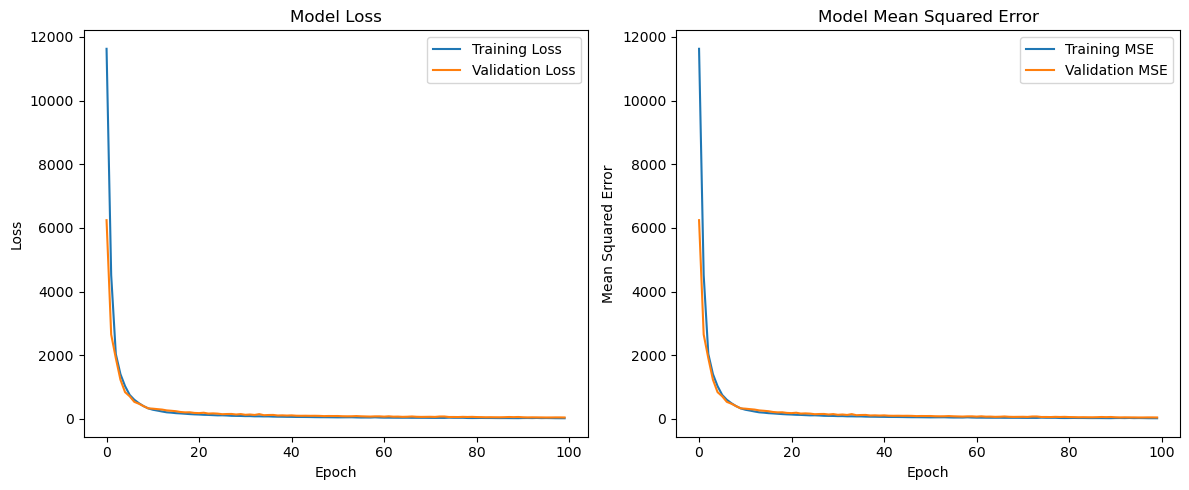

In [595]:
plot_history(history_1)

#### Forecasting and evaluation

Let's make a forecast. For simplicity we are going to use part of the validation data.

In [596]:
# 1 window of size window size

start_time = 44

x_pred = val_data[start_time:start_time+window_size]

x_pred.shape # window_size, num_features

(14, 5)

In [597]:
x_pred[np.newaxis].shape # add batch size

(1, 14, 5)

In [598]:
model_1.predict(x_pred[np.newaxis])

1/1 [==============================] - 0s 46ms/step


array([[5.99]], dtype=float32)

Let's make forecasts in the right way.

In [599]:
make_forecast(model_1, x_pred, 3, verbose=True)

Input window:
[[ 17.9   0.8  46.    2.2  30.7]
 [ 18.3   0.7  50.    2.   27.2]
 [ 19.4   0.9  51.    3.4  25.7]
 [ 20.2   1.3  64.    4.5  24.1]
 [ 19.6   1.4 138.    4.7  24.9]
 [ 18.5   1.5 137.    6.   27.8]
 [ 17.8   2.7 303.   11.7  30.3]
 [ 16.6   2.5 204.    8.2  34. ]
 [ 15.5   1.4  95.    5.1  37. ]
 [ 14.8   2.8 347.   13.   39.5]
 [ 14.5   2.1 252.    7.   42. ]
 [ 14.1   1.1  66.    3.9  44.9]
 [ 14.2   0.7  45.    2.2  45.5]
 [ 14.1   0.4  36.    1.3  45.3]]
Predicted temp: 5.9903950691223145

Input window:
[[ 18.3    0.7   50.     2.    27.2 ]
 [ 19.4    0.9   51.     3.4   25.7 ]
 [ 20.2    1.3   64.     4.5   24.1 ]
 [ 19.6    1.4  138.     4.7   24.9 ]
 [ 18.5    1.5  137.     6.    27.8 ]
 [ 17.8    2.7  303.    11.7   30.3 ]
 [ 16.6    2.5  204.     8.2   34.  ]
 [ 15.5    1.4   95.     5.1   37.  ]
 [ 14.8    2.8  347.    13.    39.5 ]
 [ 14.5    2.1  252.     7.    42.  ]
 [ 14.1    1.1   66.     3.9   44.9 ]
 [ 14.2    0.7   45.     2.2   45.5 ]
 [ 14.1    0.4   

array([ 5.99 , 15.627, 13.855], dtype=float32)

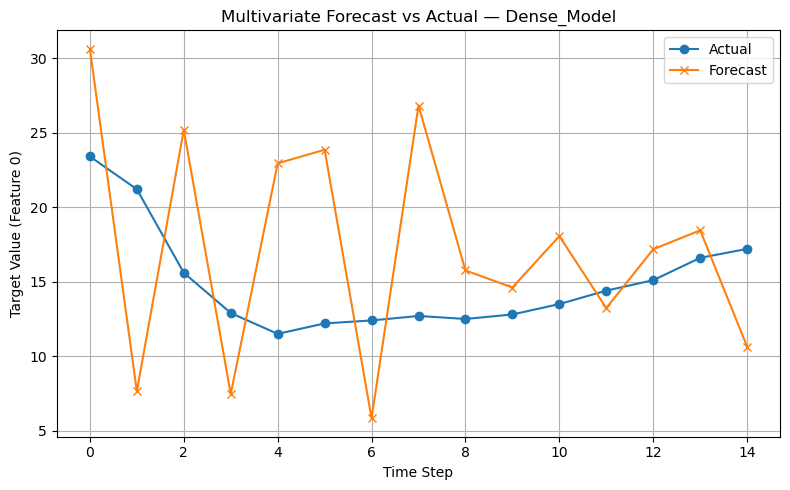

In [600]:
# true labels
test_labels = get_true_future_labels(ds_val, window_size, forecast_horizon)

# initial window
initial_window = get_initial_window(ds_val)

# forecast
f1, r1 = pred_eval(model_1, initial_window, test_labels, X_test=None, validation_steps=forecast_horizon, do_plot=True)

In [601]:
r1

{'mae': 6.7214866, 'mse': 63.51174, 'rmse': 7.969425, 'mape': 46.824825}

#### Model Performance Summary

- MAE (Mean Absolute Error): 6.72  
  - On average, the model's predictions deviate from the true values by about 6.72 units. This indicates the typical size of prediction errors.


- MSE (Mean Squared Error): 63.51  
  - The squared errors are relatively large, which suggests some predictions have larger errors impacting the overall score.


- RMSE (Root Mean Squared Error): 7.97  
  - The RMSE confirms the average error magnitude is around 8 units, emphasizing larger errors more than MAE.


- MAPE (Mean Absolute Percentage Error): 46.82%  
  - The model's predictions have an average percentage error of approximately 47%, which indicates considerable relative error, suggesting the model may struggle with accuracy on this dataset.

#### Conclusion

While the absolute errors (MAE, RMSE) show moderate deviation, the high MAPE suggests the model's predictions could be significantly off in relative terms. This indicates room for improvement, especially in reducing relative prediction errors.


<a name="5.2"></a>
### <font color='#2471a3'> <b> 5.2. LSTM </font> </b>

In [615]:
window_size = 24
horizon = 1
forecast_horizon = 15

In [616]:
ds_train = windowed_dataset(train_data, window_size, G.BATCH_SIZE, G.SHUFFLE_BUFFER_SIZE, True)
ds_val = windowed_dataset(val_data, window_size, G.BATCH_SIZE, G.SHUFFLE_BUFFER_SIZE, False)

In [42]:

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

def build_compile_model_2(name, window_size=window_size, num_features=num_features, horizon=horizon):
    model = tf.keras.Sequential(name=name)

    # LSTM Layer to handle time series input
    model.add(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window_size, num_features)))
    model.add(tf.keras.layers.LSTM(64))

    # Dense layer to output the final temperature prediction
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(horizon))


    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model
    model.compile(loss='mse',
                  optimizer=optimizer, # 'adam'
                  metrics=['mse'])

    return model


model_2 = build_compile_model_2('LSTM', window_size)
model_2.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 53057 (207.25 KB)
Trainable params: 53057 (207.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [618]:
# fit
history_2 = model_2.fit(
    ds_train, 
    epochs=150,
    verbose=0,
    validation_data=ds_val)

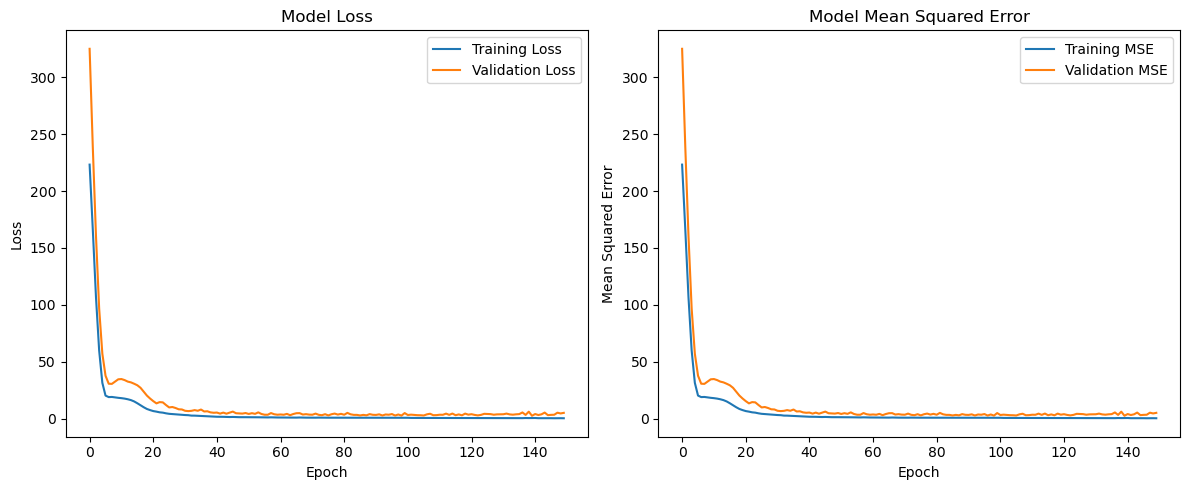

In [619]:
plot_history(history_2)

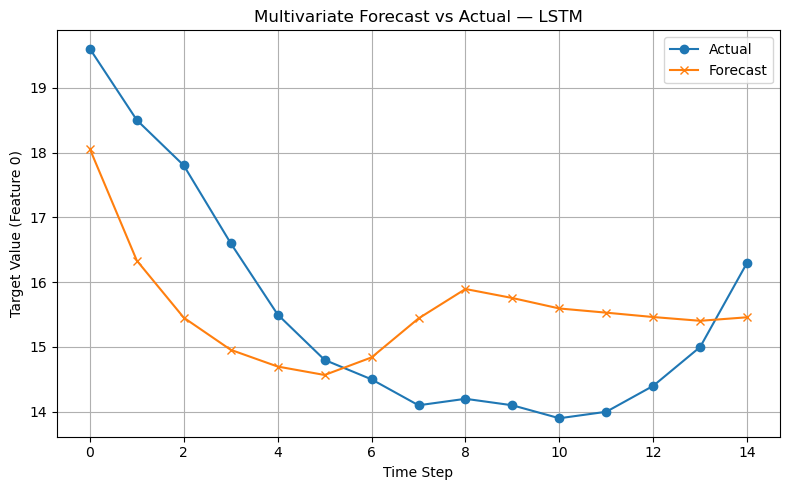

In [628]:
# true labels
test_labels = get_true_future_labels(ds_val, window_size, forecast_horizon) 

# initial window
initial_window = get_initial_window(ds_val)

# forecast
f2, r2 = pred_eval(model_2, initial_window, test_labels, X_test=None, validation_steps=forecast_horizon, do_plot=True)

In [621]:
r2

{'mae': 1.2865776, 'mse': 2.04865, 'rmse': 1.4313107, 'mape': 8.219394}

#### Model Performance Summary

- MAE (Mean Absolute Error): 1.29  
  - The average prediction error is about 1.29 units, indicating close alignment between predicted and actual values.

- MSE (Mean Squared Error): 2.05  
  -The squared errors are low, suggesting that large errors are rare.

- RMSE (Root Mean Squared Error): 1.43  
  - The RMSE confirms that typical prediction errors are around 1.43 units, reinforcing the model’s accuracy.

- MAPE (Mean Absolute Percentage Error): 8.22%  
  With an average percentage error of just over 8%, the model demonstrates good relative accuracy.


#### Conclusion

This model shows better predictive performance with low absolute and relative errors.


<a name="5.3"></a>
### <font color='#2471a3'> <b> 5.3. LSTM with Data Normalization</font> </b>

Let's see if we can achieve better results by normalizing the data.

#### Preparing data


In [38]:
window_size = 24
horizon = 1
forecast_horizon = 15

In [39]:
from sklearn.preprocessing import StandardScaler

# Normalize using training data statistics
scaler = StandardScaler()
scaler.fit(train_data)  # Fit only on the training data

# Apply the normalization to all sets
train_data_std = scaler.transform(train_data)
val_data_std = scaler.transform(val_data)

In [40]:
ds_train_std = windowed_dataset(train_data_std, window_size, G.BATCH_SIZE, G.SHUFFLE_BUFFER_SIZE, False)
ds_val_std = windowed_dataset(val_data_std, window_size, G.BATCH_SIZE, G.SHUFFLE_BUFFER_SIZE, False)

#### Build, compile and train the model

We will use the same model as in the previous section.

In [43]:
model = build_compile_model_2('LSTM_Data_Norm', window_size)

# fit
history_3 = model.fit(
    ds_train_std, 
    epochs=100, 
    verbose=0,
    validation_data=ds_val_std)

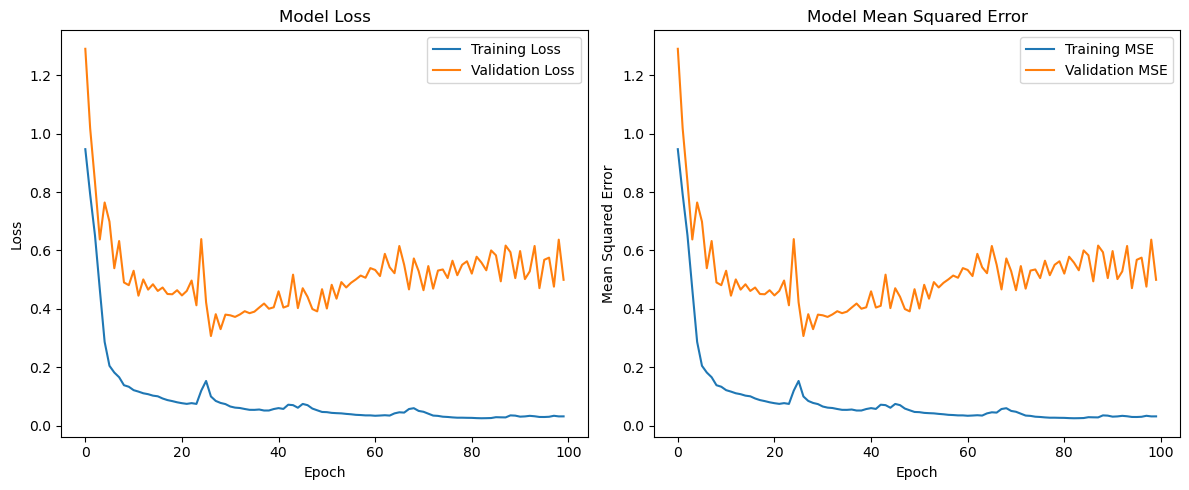

In [44]:
plot_history(history_3)

#### Forecast and evaluation

To make a prediction, first, we need to normalize the input data.

In [45]:
start_time = 44

x_pred = val_data[start_time:start_time+window_size]

pred_norm = model.predict(scaler.transform(x_pred)[np.newaxis])
pred_norm

1/1 [==============================] - 1s 533ms/step


array([[0.33]], dtype=float32)

Note that our prediction is normalized, we have to de-normalize it.

In [46]:
# I have to de-normalize temperature (my prediction)
temperature_predictions = scaler.inverse_transform(
    np.concatenate([pred_norm.reshape(-1, 1),
                    np.zeros((1, num_features - 1))], axis=1)
)[:, 0]  # Select only the temperature column after inverse transform

temperature_predictions


array([16.078])

#### Forecast and evaluation.

Note that we have to calculate the metrics with the unnormalized data.

In [47]:
def invert_scaled_temperature(preds_scaled, scaler, num_features):
    """
    Inverse transforms scaled temperature predictions back to original scale.

    Parameters:
    - preds_scaled: np.ndarray of shape (n,) or (n, 1), scaled temperature predictions.
    - scaler: fitted scaler object with inverse_transform method (e.g., sklearn StandardScaler).
    - num_features: int, total number of features used in scaling.

    Returns:
    - preds_original: np.ndarray of shape (n,), temperature predictions in original scale.
    """
    # Ensure shape is (n, 1)
    preds_std = preds_scaled.reshape(-1, 1)

    # Create array with temperature preds in column 0, rest zeros
    temp_and_zeros = np.concatenate([
        preds_std,
        np.zeros((len(preds_std), num_features - 1))
    ], axis=1)

    # Apply inverse transform and extract temperature column
    preds_original = scaler.inverse_transform(temp_and_zeros)[:, 0]

    return preds_original


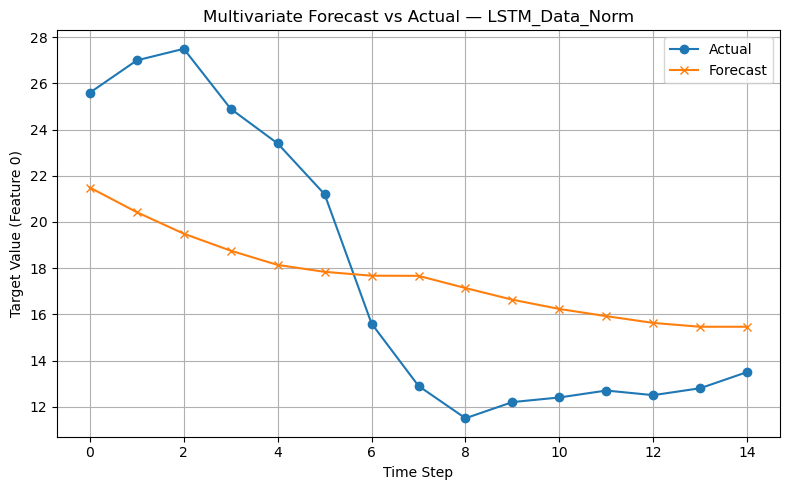

In [90]:
# true labels (unnormalized); to compare
temp_labels = val_data[:, 0] # only temperature
temp_labels = temp_labels[window_size:window_size+forecast_horizon]

# initial window (should be a normalized one, that is what my model expects)
initial_window = get_initial_window(ds_val_std) # Should be (window_size, num_features)

# make forecast
f3_norm = make_forecast(model, initial_window, forecast_horizon, verbose=False)

# unnormalized preds
f3 = invert_scaled_temperature(f3_norm, scaler, num_features)

# Evaluate predictions against the true values
r3 = evaluate_preds(temp_labels, f3)
    
# plot comparison
plot_comparison(temp_labels, f3, forecast_horizon, model.name)


In [91]:
r3

{'mae': 4.3451533, 'mse': 21.681509, 'rmse': 4.6563406, 'mape': 25.652802}

#### Model Performance Summary

- MAE (Mean Absolute Error): 4.35  
  - On average, the model’s predictions deviate from the actual values by about 4.35 units.

- MSE (Mean Squared Error): 21.68  
  - The squared errors indicate a moderate level of overall prediction error, with larger errors contributing more heavily.

- RMSE (Root Mean Squared Error): 4.66  
  - This confirms that typical prediction errors are around 4.66 units, emphasizing the impact of larger errors.

- MAPE (Mean Absolute Percentage Error): 25.65%  
  - The average prediction error relative to the true values is about 25.7%, indicating that while the model is moderately accurate, there’s still room for improvement in terms of relative error.

---

#### Conclusion

The model demonstrates **moderate accuracy**. The absolute errors (MAE and RMSE) suggest decent performance, but the MAPE around 25% highlights that relative errors could be significant in some cases, especially for smaller true values. Further tuning or additional features may help improve predictive performance.


<a name="#annex"></a>
## <font color='#1a5276'> <b> Annex </b> </font> 

<a name="A"></a>
### <font color='#2471a3'> <b> A. About Standarization</font> </b>

In this case, we used a `StandardScaler` to normalize **all input features**, including the target variable (temperature), before training the model. However, the model is trained to **predict only one target: temperature**, not all features.

After prediction, the output values are in the standardized (normalized) scale—i.e., the scale used during training, where the temperature feature had zero mean and unit variance. To interpret the results in real-world units (e.g., °C), we must invert this transformation.

---

The `scaler.inverse_transform()` expects the same number of features it was originally fitted on (in this case, 5). Since we only have the standardized temperature predictions, we must create a dummy input array with:

- The predicted temperatures in column 0, and  
- Zeros in the remaining columns (features 1 to 4).

This way, we maintain the correct shape and alignment of features, and the scaler can apply the inverse transformation properly.

Even though we only care about temperature, the scaler was trained on all features together, so it needs a full input row to apply the inverse scaling. Finally, we extract only the first column from the result, which corresponds to the denormalized temperature.

---

#### Summary

You need to reconstruct the full input shape with zeros for non-target features so that `scaler.inverse_transform()` works correctly and returns the temperature predictions in original units.


In [93]:
# Your predicted standardized temperatures
preds_scaled = np.array([
    1.144, 1.006, 0.898, 0.817, 0.764, 0.724, 0.693, 0.672, 0.655, 0.638,
    0.625, 0.614, 0.606, 0.601, 0.597, 0.598, 0.601, 0.605, 0.607, 0.608,
    0.609, 0.609, 0.609, 0.611, 0.614, 0.616, 0.617, 0.618, 0.618, 0.617
], dtype=np.float32)

# Assume you have 5 features and a fitted scaler
num_features = 5

# Create dummy inputs with temperature in column 0 and zeros elsewhere
dummy_input = np.concatenate([
    preds_scaled.reshape(-1, 1),                     # temperature (column 0)
    np.zeros((len(preds_scaled), num_features - 1))  # dummy columns 1–4
], axis=1)

# Apply inverse transformation
preds_original = scaler.inverse_transform(dummy_input)[:, 0]

# Result: array of predicted temperatures in original units
print(preds_original)

[19.649 19.043 18.57  18.214 17.982 17.806 17.67  17.578 17.503 17.429 17.372 17.324 17.288 17.267 17.249 17.253 17.267
 17.284 17.293 17.297 17.302 17.302 17.302 17.31  17.324 17.332 17.337 17.341 17.341 17.337]


<a name="References"></a>
## <font color='#1a5276'> <b> 6. References </font> </b>

[DeepLearning.AI TensorFlow Developer Professional Certificate](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction?specialization=tensorflow-in-practice)

[TensorFlow for Deep Learning Bootcamp](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/?couponCode=MTST7102224B2)